In [1]:
!ls 

Fairness_on_Regression_Tasks.ipynb data_exploration.ipynb
README.md                          dataset-cleaning.ipynb
data


In [2]:
!ls data/*

data/communities.data
data/communities.names
data/communities_and_crime.csv
data/communities_and_crime_clean.csv
data/communities_and_crime_cleaner_no_unknowns.csv


In [3]:
import tensorflow as tf
import pandas as pd
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.5f}'.format
tf.logging.set_verbosity(tf.logging.ERROR)
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
import math
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import keras

Using TensorFlow backend.


In [4]:
data = pd.read_csv("data/communities_and_crime_clean.csv")

In [5]:
data.head()

,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
0,1,0.19000,0.33000,0.02000,0.90000,0.12000,0.17000,0.34000,0.47000,0.29000,...,0.12000,0.42000,0.50000,0.51000,0.64000,0.12000,0.26000,0.20000,0.32000,0.20000
1,1,0.00000,0.16000,0.12000,0.74000,0.45000,0.07000,0.26000,0.59000,0.35000,...,0.21000,0.50000,0.34000,0.60000,0.52000,0.02000,0.12000,0.45000,0.00000,0.67000
2,1,0.00000,0.42000,0.49000,0.56000,0.17000,0.04000,0.39000,0.47000,0.28000,...,0.14000,0.49000,0.54000,0.67000,0.56000,0.01000,0.21000,0.02000,0.00000,0.43000
3,1,0.04000,0.77000,1.00000,0.08000,0.12000,0.10000,0.51000,0.50000,0.34000,...,0.19000,0.30000,0.73000,0.64000,0.65000,0.02000,0.39000,0.28000,0.00000,0.12000
4,1,0.01000,0.55000,0.02000,0.95000,0.09000,0.05000,0.38000,0.38000,0.23000,...,0.11000,0.72000,0.64000,0.61000,0.53000,0.04000,0.09000,0.02000,0.00000,0.03000


In [6]:
data.shape

(1994, 101)

In [7]:
data.to_csv("data/communities_and_crime_cleaner_no_unknowns.csv")

In [8]:
def train_test_split(data, folds=[10]):
    folds = set(folds)
    training_data = data.copy()
    test_data = None
    for fold_number in folds:
        training_data = training_data[training_data.fold != fold_number]
        new_test_data = data[data.fold == fold_number]
        if test_data is None:
            test_data = new_test_data
        else:
            test_data = pd.concat([test_data, new_test_data])
    return training_data, test_data

In [9]:
training_data, test_data = train_test_split(data, folds=[10])

In [10]:
training_data.shape,test_data.shape

((1795, 101), (199, 101))

In [11]:
training_data.describe()

,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
count,1795.00000,1795.00000,1795.00000,1795.00000,1795.00000,1795.00000,1795.00000,1795.00000,1795.00000,1795.00000,...,1795.00000,1795.00000,1795.00000,1795.00000,1795.00000,1795.00000,1795.00000,1795.00000,1795.00000,1795.00000
mean,4.99443,0.05714,0.46432,0.17949,0.75329,0.15374,0.14490,0.42489,0.49388,0.33678,...,0.21590,0.60812,0.53499,0.62622,0.65119,0.06529,0.23136,0.16296,0.09469,0.23915
std,2.58306,0.12531,0.16463,0.25386,0.24489,0.20809,0.23371,0.15645,0.14433,0.16816,...,0.23148,0.20476,0.18160,0.20125,0.19869,0.10789,0.20144,0.22988,0.24097,0.23554
min,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,3.00000,0.01000,0.35000,0.02000,0.63000,0.04000,0.01000,0.33000,0.41000,0.25000,...,0.06000,0.47000,0.42000,0.53000,0.56000,0.02000,0.10000,0.02000,0.00000,0.07000
50%,5.00000,0.02000,0.44000,0.06000,0.85000,0.08000,0.04000,0.40000,0.47000,0.29000,...,0.13000,0.63000,0.55000,0.67000,0.70000,0.04000,0.17000,0.07000,0.00000,0.15000
75%,7.00000,0.05000,0.54000,0.23000,0.94000,0.17000,0.16000,0.47000,0.54000,0.36000,...,0.28000,0.77500,0.66000,0.77000,0.79000,0.07000,0.28000,0.19000,0.00000,0.33000
max,9.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,...,1.00000,1.00000,0.99000,0.99000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000


In [12]:
test_data.describe()

,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
count,199.00000,199.00000,199.00000,199.00000,199.00000,199.00000,199.00000,199.00000,199.00000,199.00000,...,199.00000,199.00000,199.00000,199.00000,199.00000,199.00000,199.00000,199.00000,199.00000,199.00000
mean,10.00000,0.06166,0.45503,0.18090,0.75754,0.15317,0.13613,0.41819,0.49372,0.33161,...,0.21241,0.61583,0.53563,0.62824,0.65462,0.06472,0.24633,0.15015,0.08829,0.22739
std,0.00000,0.14077,0.15538,0.25030,0.23681,0.21638,0.22156,0.14361,0.13681,0.15111,...,0.22850,0.20077,0.17953,0.19428,0.19442,0.12300,0.21753,0.22168,0.23498,0.20881
min,10.00000,0.00000,0.08000,0.00000,0.00000,0.01000,0.00000,0.03000,0.05000,0.03000,...,0.00000,0.00000,0.06000,0.00000,0.00000,0.00000,0.02000,0.00000,0.00000,0.01000
25%,10.00000,0.01000,0.35000,0.02000,0.64000,0.03000,0.01000,0.35000,0.42000,0.26000,...,0.05000,0.47000,0.41500,0.50500,0.53500,0.02000,0.10000,0.02000,0.00000,0.08000
50%,10.00000,0.02000,0.43000,0.07000,0.85000,0.06000,0.04000,0.40000,0.48000,0.30000,...,0.12000,0.66000,0.54000,0.66000,0.71000,0.04000,0.17000,0.06000,0.00000,0.16000
75%,10.00000,0.06000,0.53500,0.22000,0.94000,0.16000,0.15000,0.47000,0.54000,0.35500,...,0.31000,0.77500,0.65000,0.77000,0.78500,0.07000,0.31500,0.18000,0.00000,0.29000
max,10.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,...,1.00000,1.00000,1.00000,1.00000,0.94000,1.00000,1.00000,1.00000,1.00000,1.00000


### Violent crimes per population 

Text(0, 0.5, 'racePctWhite')

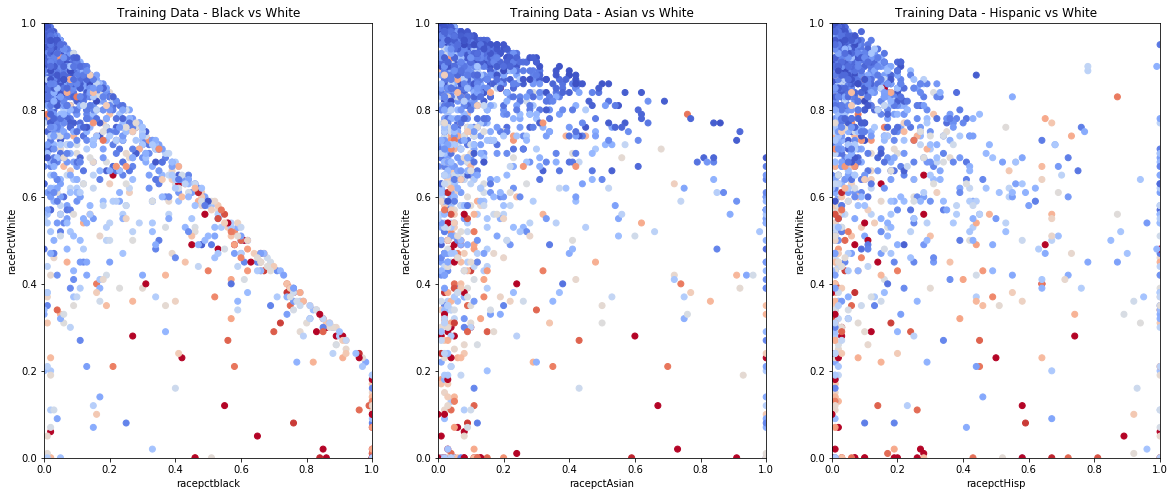

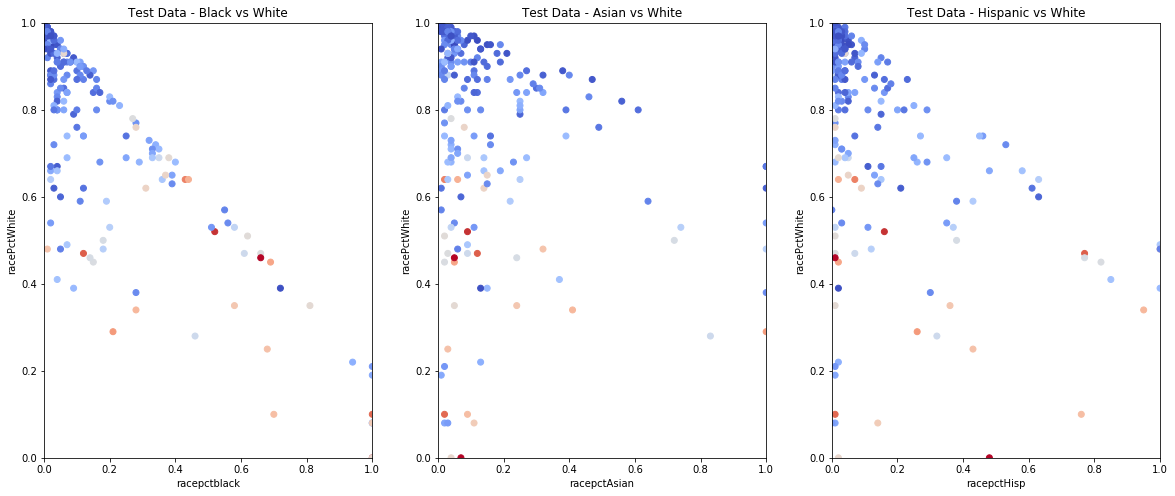

In [13]:

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(131)
ax.set_title("Training Data - Black vs White")
ax.set_autoscaley_on(False)
ax.set_ylim([0, 1])
ax.set_autoscalex_on(False)
ax.set_xlim([0, 1])

ax.set_xlabel("racepctblack")
ax.set_ylabel("racePctWhite")

plt.scatter(training_data['racepctblack'],training_data['racePctWhite'], cmap='coolwarm', c=training_data['ViolentCrimesPerPop'])

ax = plt.subplot(1, 3, 2)
ax.set_title("Training Data - Asian vs White")
ax.set_autoscaley_on(False)
ax.set_ylim([0, 1])
ax.set_autoscalex_on(False)
ax.set_xlim([0, 1])

ax.set_xlabel("racepctAsian")
ax.set_ylabel("racePctWhite")

plt.scatter(training_data['racePctAsian'], training_data['racePctWhite'], cmap='coolwarm', c=training_data['ViolentCrimesPerPop'])

ax = plt.subplot(1, 3, 3)
ax.set_title("Training Data - Hispanic vs White")
ax.set_autoscaley_on(False)
ax.set_ylim([0, 1])
ax.set_autoscalex_on(False)
ax.set_xlim([0, 1])

plt.scatter(training_data['racePctHisp'], training_data['racePctWhite'], cmap='coolwarm', c=training_data['ViolentCrimesPerPop'])
ax.set_xlabel("racepctHisp")
ax.set_ylabel("racePctWhite")


## For validation data


fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(131)
ax.set_title("Test Data - Black vs White")
ax.set_autoscaley_on(False)
ax.set_ylim([0, 1])
ax.set_autoscalex_on(False)
ax.set_xlim([0, 1])

ax.set_xlabel("racepctblack")
ax.set_ylabel("racePctWhite")

plt.scatter(test_data['racepctblack'],test_data['racePctWhite'], cmap='coolwarm', c=test_data['ViolentCrimesPerPop'])

ax = plt.subplot(1, 3, 2)
ax.set_title("Test Data - Asian vs White")
ax.set_autoscaley_on(False)
ax.set_ylim([0, 1])
ax.set_autoscalex_on(False)
ax.set_xlim([0, 1])

ax.set_xlabel("racepctAsian")
ax.set_ylabel("racePctWhite")

plt.scatter(test_data['racePctAsian'], test_data['racePctWhite'], cmap='coolwarm', c=test_data['ViolentCrimesPerPop'])

ax = plt.subplot(1, 3, 3)
ax.set_title("Test Data - Hispanic vs White")
ax.set_autoscaley_on(False)
ax.set_ylim([0, 1])
ax.set_autoscalex_on(False)
ax.set_xlim([0, 1])

plt.scatter(test_data['racePctHisp'], test_data['racePctWhite'], cmap='coolwarm', c=test_data['ViolentCrimesPerPop'])
ax.set_xlabel("racepctHisp")
ax.set_ylabel("racePctWhite")

### Train model on the data

In [14]:
import keras
from keras.layers import Dense
from keras import optimizers

In [15]:
VIOLENT_CRIMES_PER_POP = "ViolentCrimesPerPop"
FOLD = "fold"
training_input, training_targets = training_data.drop([FOLD, VIOLENT_CRIMES_PER_POP], axis=1), training_data[VIOLENT_CRIMES_PER_POP]
test_input, test_targets = test_data.drop([FOLD, VIOLENT_CRIMES_PER_POP], axis=1), test_data[VIOLENT_CRIMES_PER_POP]

In [16]:
training_input.keys()

Index(['population', 'householdsize', 'racepctblack', 'racePctWhite',
       'racePctAsian', 'racePctHisp', 'agePct12t21', 'agePct12t29',
       'agePct16t24', 'agePct65up', 'numbUrban', 'pctUrban', 'medIncome',
       'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWPubAsst',
       'pctWRetire', 'medFamInc', 'perCapInc', 'whitePerCap', 'blackPerCap',
       'indianPerCap', 'AsianPerCap', 'HispPerCap', 'NumUnderPov',
       'PctPopUnderPov', 'PctLess9thGrade', 'PctNotHSGrad', 'PctBSorMore',
       'PctUnemployed', 'PctEmploy', 'PctEmplManu', 'PctEmplProfServ',
       'PctOccupManu', 'PctOccupMgmtProf', 'MalePctDivorce', 'MalePctNevMarr',
       'FemalePctDiv', 'TotalPctDiv', 'PersPerFam', 'PctFam2Par',
       'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par', 'PctWorkMomYoungKids',
       'PctWorkMom', 'NumIlleg', 'PctIlleg', 'NumImmig', 'PctImmigRecent',
       'PctImmigRec5', 'PctImmigRec8', 'PctImmigRec10', 'PctRecentImmig',
       'PctRecImmig5', 'PctRecImmig8', 'PctRec

### Attempt 1: Keras model

In [17]:
INPUT_SIZE = len(training_input.keys())

In [18]:

def build_model():
    model = keras.Sequential([
        Dense(64, activation='relu', input_shape=[INPUT_SIZE]),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    
    rmsprop = keras.optimizers.RMSprop(0.001)
    sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='mse', optimizer = sgd,  metrics=['mae', 'mse'])
    return model
    
model = build_model()
model.summary()
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                6400      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 8,513
Trainable params: 8,513
Non-trainable params: 0
_________________________________________________________________


In [19]:
example_batch = training_input[:10]
example_output = model.predict(example_batch)

Text(0, 0.5, 'Untrained output')

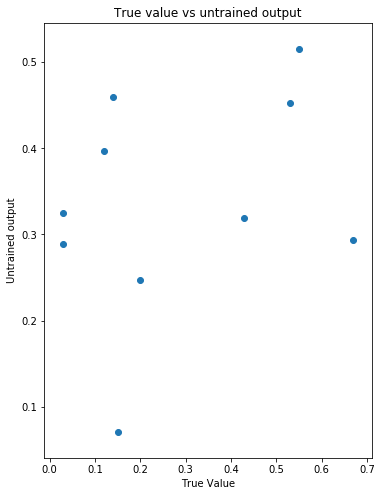

In [20]:
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(131)
ax.set_title("True value vs untrained output")
plt.scatter(training_targets[:10], example_output[:10])
plt.xlabel("True Value")
plt.ylabel("Untrained output")

In [21]:
class PrintProgress(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: 
            print('')
        print('.', end='')
            
EPOCHS = 100

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(
    training_input, training_targets, epochs=EPOCHS, validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintProgress()])


.............................................

In [22]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error,epoch
40,0.01851,0.10082,0.01851,0.01616,0.08842,0.01616,40
41,0.01780,0.09476,0.01780,0.01616,0.08847,0.01616,41
42,0.01724,0.09333,0.01724,0.01605,0.08739,0.01605,42
43,0.01743,0.09569,0.01743,0.01605,0.08784,0.01605,43
44,0.01744,0.09398,0.01744,0.01598,0.08831,0.01598,44


Text(0, 0.5, 'Prediction')

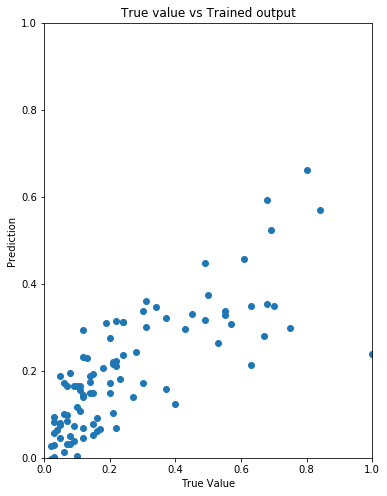

In [23]:
example_batch = training_input[:100]
example_output = model.predict(example_batch)
example_true_output = training_targets[:10]

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(131)
ax.set_title("True value vs Trained output")
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.scatter(training_targets[:100], example_output[:100])
plt.xlabel("True Value")
plt.ylabel("Prediction")

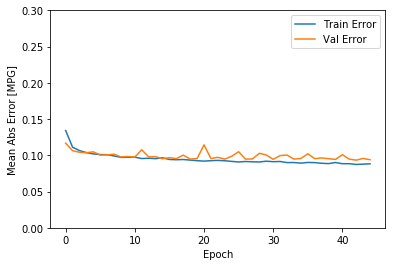

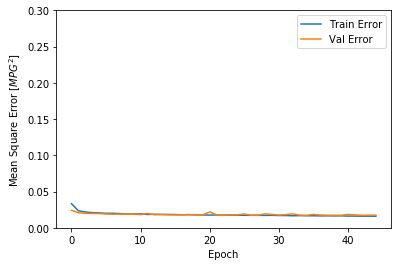

In [24]:
def plot_history(history):
    MAE = 'mean_absolute_error'
    VAL_MAE='val_mean_absolute_error'
    MSE="mean_squared_error"
    VAL_MSE = "val_mean_squared_error"
    
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist[MAE],
             label='Train Error')
    plt.plot(hist['epoch'], hist[VAL_MAE],
           label = 'Val Error')
    
    plt.ylim([0,0.3])
    plt.legend()
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist[MSE],
           label='Train Error')
    plt.plot(hist['epoch'], hist[VAL_MSE],
           label = 'Val Error')
    plt.ylim([0,0.3])
    plt.legend()
    plt.show()

plot_history(history)

In [25]:
loss, mae, mse = model.evaluate(test_input, test_targets, verbose=2)

In [26]:
print("Testing set Mean Abs Error: {:5.2f} ".format(mae))

Testing set Mean Abs Error:  0.09 


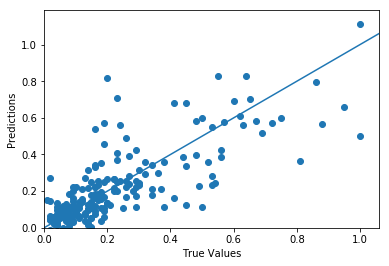

In [27]:
test_predictions = model.predict(test_input)
plt.scatter(test_targets, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-2, 2], [-2, 2])

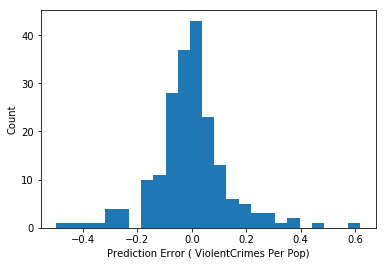

In [28]:
error = test_predictions.reshape(199) - test_targets
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error ( ViolentCrimes Per Pop)")
_ = plt.ylabel("Count")

##### Error follows gaussian distribution

In [29]:
### Bias analysis on test data


In [30]:
test_input.describe()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,NumStreet,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn
count,199.00000,199.00000,199.00000,199.00000,199.00000,199.00000,199.00000,199.00000,199.00000,199.00000,...,199.00000,199.00000,199.00000,199.00000,199.00000,199.00000,199.00000,199.00000,199.00000,199.00000
mean,0.06166,0.45503,0.18090,0.75754,0.15317,0.13613,0.41819,0.49372,0.33161,0.41658,...,0.03246,0.21241,0.61583,0.53563,0.62824,0.65462,0.06472,0.24633,0.15015,0.08829
std,0.14077,0.15538,0.25030,0.23681,0.21638,0.22156,0.14361,0.13681,0.15111,0.17924,...,0.13820,0.22850,0.20077,0.17953,0.19428,0.19442,0.12300,0.21753,0.22168,0.23498
min,0.00000,0.08000,0.00000,0.00000,0.01000,0.00000,0.03000,0.05000,0.03000,0.01000,...,0.00000,0.00000,0.00000,0.06000,0.00000,0.00000,0.00000,0.02000,0.00000,0.00000
25%,0.01000,0.35000,0.02000,0.64000,0.03000,0.01000,0.35000,0.42000,0.26000,0.29000,...,0.00000,0.05000,0.47000,0.41500,0.50500,0.53500,0.02000,0.10000,0.02000,0.00000
50%,0.02000,0.43000,0.07000,0.85000,0.06000,0.04000,0.40000,0.48000,0.30000,0.41000,...,0.00000,0.12000,0.66000,0.54000,0.66000,0.71000,0.04000,0.17000,0.06000,0.00000
75%,0.06000,0.53500,0.22000,0.94000,0.16000,0.15000,0.47000,0.54000,0.35500,0.52000,...,0.00000,0.31000,0.77500,0.65000,0.77000,0.78500,0.07000,0.31500,0.18000,0.00000
max,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,...,1.00000,1.00000,1.00000,1.00000,1.00000,0.94000,1.00000,1.00000,1.00000,1.00000


In [31]:
error.describe()

count   199.00000
mean     -0.00511
std       0.13902
min      -0.49943
25%      -0.06556
50%      -0.00367
75%       0.05039
max       0.61961
Name: ViolentCrimesPerPop, dtype: float64

In [32]:
from numpy.polynomial.polynomial import polyfit
import numpy as np

# Evaluate Estimation Error coefficient ( Group Fairness) 

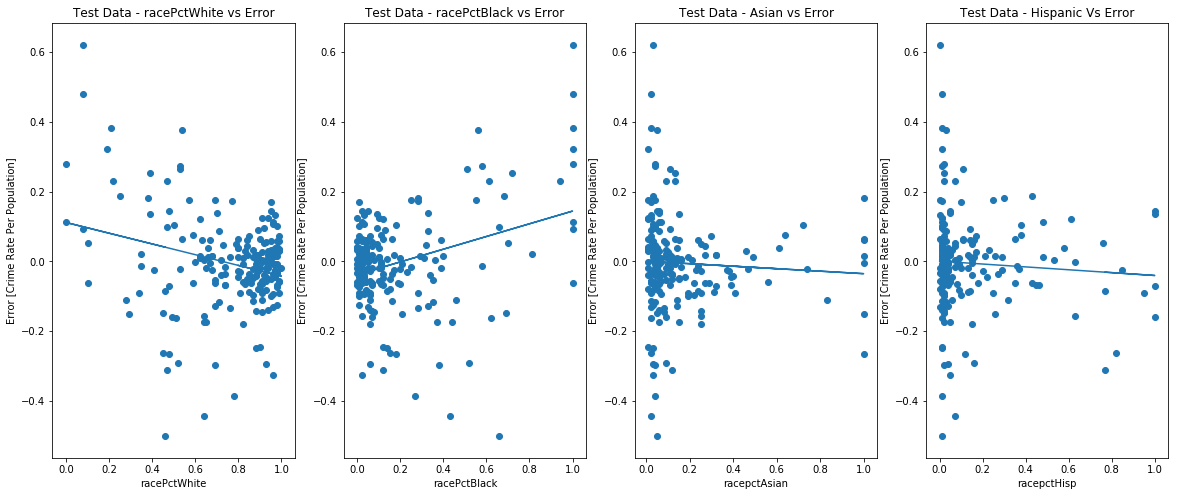

In [33]:
ERROR_LABEL = 'Error [Crime Rate Per Population]'

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(141)
ax.set_title("Test Data - racePctWhite vs Error")

ax.set_xlabel("racePctWhite")
ax.set_ylabel(ERROR_LABEL)
plt.scatter(test_data.racePctWhite,error)
b, m = polyfit(test_data.racePctWhite, error, 1)
plt.plot(test_data.racePctWhite,  b + m *test_data.racePctWhite, '-')

ax = plt.subplot(142)
ax.set_title("Test Data - racePctBlack vs Error")

ax.set_xlabel("racePctBlack")
ax.set_ylabel(ERROR_LABEL)
plt.scatter(test_data.racepctblack, error)
b, m = polyfit(test_data.racepctblack, error, 1)
plt.plot(test_data.racepctblack,  b + m *test_data.racepctblack, '-')

ax = plt.subplot(143)
ax.set_title("Test Data - Asian vs Error")
plt.scatter(test_data.racePctAsian, error)
ax.set_xlabel("racepctAsian")
ax.set_ylabel(ERROR_LABEL)
b, m = polyfit(test_data.racePctAsian, error, 1)
plt.plot(test_data.racePctAsian,  b + m *test_data.racePctAsian, '-')
              
ax = plt.subplot(144)
ax.set_title("Test Data - Hispanic Vs Error")
plt.scatter(test_data.racePctHisp, error)
ax.set_xlabel("racepctHisp")
ax.set_ylabel(ERROR_LABEL)
b, m = polyfit(test_data.racePctHisp, error, 1)
plt.plot(test_data.racePctHisp,  b + m *test_data.racePctHisp, '-')

##### Results: We see negative coefficients for racePctWhite, racePctAsian and racePctHispanic, while we see positive coefficient for racePctBlack.

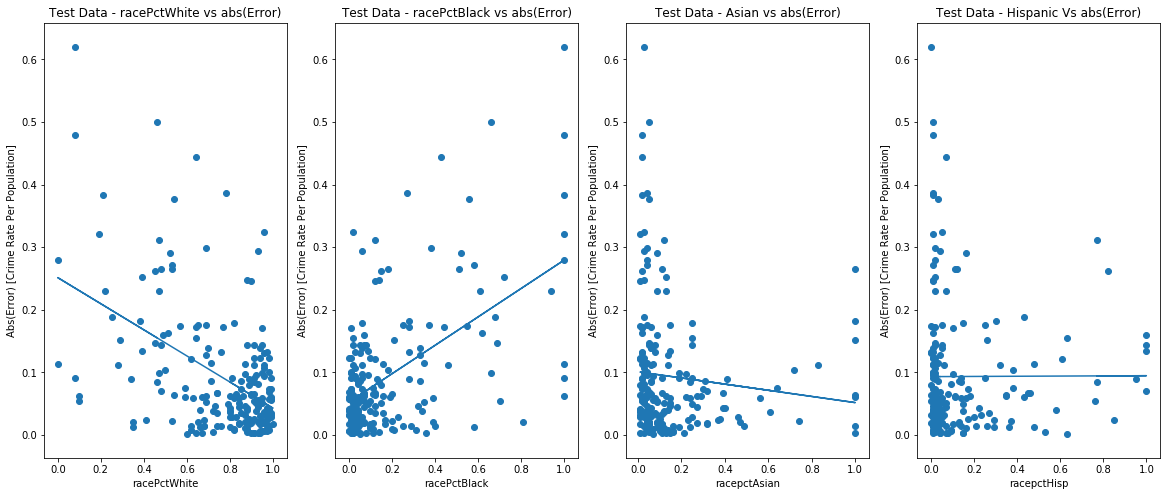

In [34]:
ERROR_LABEL = 'Abs(Error) [Crime Rate Per Population]'
abs_error = np.abs(error)

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(141)
ax.set_title("Test Data - racePctWhite vs abs(Error)")

ax.set_xlabel("racePctWhite")
ax.set_ylabel(ERROR_LABEL)
plt.scatter(test_data.racePctWhite,abs_error)
b, m = polyfit(test_data.racePctWhite, abs_error, 1)
plt.plot(test_data.racePctWhite,  b + m *test_data.racePctWhite, '-')

ax = plt.subplot(142)
ax.set_title("Test Data - racePctBlack vs abs(Error)")

ax.set_xlabel("racePctBlack")
ax.set_ylabel(ERROR_LABEL)
plt.scatter(test_data.racepctblack, abs_error)
b, m = polyfit(test_data.racepctblack, abs_error, 1)
plt.plot(test_data.racepctblack,  b + m *test_data.racepctblack, '-')

ax = plt.subplot(143)
ax.set_title("Test Data - Asian vs abs(Error)")
plt.scatter(test_data.racePctAsian, abs_error)
ax.set_xlabel("racepctAsian")
ax.set_ylabel(ERROR_LABEL)
b, m = polyfit(test_data.racePctAsian, abs_error, 1)
plt.plot(test_data.racePctAsian,  b + m *test_data.racePctAsian, '-')
              
ax = plt.subplot(144)
ax.set_title("Test Data - Hispanic Vs abs(Error)")
plt.scatter(test_data.racePctHisp, abs_error)
ax.set_xlabel("racepctHisp")
ax.set_ylabel(ERROR_LABEL)
b, m = polyfit(test_data.racePctHisp, abs_error, 1)
plt.plot(test_data.racePctHisp,  b + m *test_data.racePctHisp, '-')

## Evaluate consistency ( Individual Fairness)

In [35]:
def euclidean_distance(vec1, vec2):
    diff = vec1 - vec2
    out = np.sqrt(np.dot(diff, diff.T))
    return out

def get_prediction_difference(input_dataset):
    predictions = model.predict(input_dataset)
    difference_matrix = None

def cosine_distance(vec1, vec2):
    # TODO(audace) Implement cosine distance
    pass

In [36]:
# TODO(audace): Vectorize
test_input_np = np.array(test_input)
test_input_np.shape
n_rows = test_input.shape[0]
results_list = [[], []]
for index_1 in range(n_rows):
    for index_2 in range(n_rows):
        vec1 = test_input_np[index_1,:].reshape((1, 99))
        vec2 = test_input_np[index_2, :].reshape((1, 99))
        distance = euclidean_distance(vec1, vec2)
        prediction_difference = np.abs(model.predict(vec1) - model.predict(vec2)).reshape((1,))
        results_list[0].append(distance.flatten()[0])
        results_list[1].append(prediction_difference.flatten()[0])

Text(0, 0.5, 'Prediction Difference')

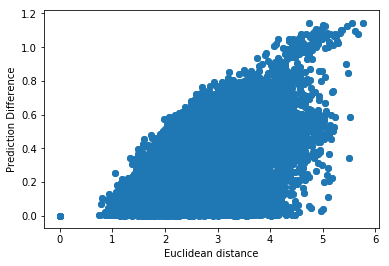

In [37]:
plt.figure()
plt.scatter(results_list[0], results_list[1])
plt.xlabel("Euclidean distance")
plt.ylabel("Prediction Difference")

### Architecture 2: Linear regressor with tensorflow LinearRegressor

In [43]:
from tensorflow.python.data import Dataset
from sklearn import metrics
tf.logging.set_verbosity(tf.logging.ERROR)

In [44]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    ## Convert data into a dict of np array
    features = {key: np.array(value) for key, value in dict(features).items()}
    
    ## Construct dataset, and consider batching and repeating
    ds = Dataset.from_tensor_slices((features, targets)) # 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
        ds = ds.shuffle(10000)
        
    # Return the next batch of data
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

def construct_feature_columns(input_features):
    """
    features: the names of numerical features to use
    Returns a set of feature column
    """
    return set([tf.feature_column.numeric_column(my_feature) for my_feature in input_features])

def train_model(learning_rate, steps, batch_size, training_examples, training_targets, validation_examples, validation_targets):
    
    """Trains a linear regression model of multiple features.
    
    In addition to training, this function also prints training progress information, as well as a plot of the training and validation loss over time.
    
    Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
    Returns:
    A `LinearRegressor` object trained on the training data.
    """
    periods = 10
    steps_per_period = steps/periods
    
    
    # Create a linear regression object
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(feature_columns=construct_feature_columns(training_examples), optimizer=my_optimizer)
    
    
    
    training_input_fn = lambda: my_input_fn(training_examples, training_targets[VIOLENT_CRIMES_PER_POP], batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples, training_targets[VIOLENT_CRIMES_PER_POP], num_epochs=1, shuffle=False)
    predict_validation_input_fn = lambda : my_input_fn(validation_examples, validation_targets[VIOLENT_CRIMES_PER_POP], num_epochs=1, shuffle=False)
    
    print("Training model ..... ")
    print("RMSE on the data .... ")
    training_rmse = []
    validation_rmse = []
    
    for period in range(0, periods):
        # train the model, starting from the prior state
        linear_regressor.train(input_fn = training_input_fn, steps=steps_per_period)
        
        # Take a break and compute predictions
        training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
        
        validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
        
        
        
        ## Compute training and validation loss
        training_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(validation_predictions, validation_targets))
        
        ## Occasionally print the current loss
        # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
        
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
        
    print("Model training finished.")
    
     # Output a graph of loss metrics over periods.
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()
    
    return linear_regressor
    

In [50]:
new_training_data.fold.unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [51]:
new_training_data, new_validation_data = train_test_split(training_data, folds =[5])
assert new_training_data.shape[0] > 0 and new_validation_data.shape[0]  > 0

new_training_targets, new_validation_targets = pd.DataFrame(), pd.DataFrame()
new_training_examples, new_training_targets[VIOLENT_CRIMES_PER_POP] = new_training_data.drop([VIOLENT_CRIMES_PER_POP], axis=1), new_training_data[VIOLENT_CRIMES_PER_POP]
new_validation_examples, new_validation_targets[VIOLENT_CRIMES_PER_POP] = new_validation_data.drop([VIOLENT_CRIMES_PER_POP], axis=1), new_validation_data[VIOLENT_CRIMES_PER_POP]


In [52]:
construct_feature_columns(new_training_examples)

{NumericColumn(key='AsianPerCap', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='FemalePctDiv', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='HispPerCap', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='HousVacant', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='LandArea', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='LemasPctOfficDrugUn', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='MalePctDivorce', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='MalePctNevMarr', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='MedNumBR', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='MedOwnCostPctInc', shape=(1,

In [ ]:
linear_regressor = train_model(learning_rate =0.00001, steps=100, batch_size=1, training_examples=new_training_examples, training_targets=new_training_targets, validation_examples=new_validation_examples, validation_targets=new_validation_targets)

Training model ..... 
RMSE on the data .... 


In [ ]:
### Run tests on the linear regressor